In [1]:
mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" -O ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2021-10-25 11:13:55--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2021-10-25 11:13:56 (399 MB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



In [2]:
pip install psycopg2-binary

In [3]:
import psycopg2
conn = psycopg2.connect("""
    host=rc1c-5lsfxv5qer0uol30.mdb.yandexcloud.net
    port=6432
    dbname=olist
    user=user1
    password=olistolist
    target_session_attrs=read-write
    sslmode=verify-full
""") 

In [4]:
import pandas as pd
import numpy as np
import pandas.io.sql as psql
import seaborn as sns
import matplotlib.pyplot as plt
import math
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords 
from nltk.stem import SnowballStemmer
import re
from math import sqrt
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from scipy.stats import sem
from scipy.stats import t

In [5]:
q = conn.cursor()
q.execute('SELECT version()')
print(q.fetchone())

('PostgreSQL 13.4 (Ubuntu 13.4-201-yandex.50204.1072273362) on x86_64-pc-linux-gnu, compiled by gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0, 64-bit',)


In [6]:
# список таблиц
q = conn.cursor()
q.execute("select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)';")
print( q.fetchall())

[('order_items',), ('orders',), ('order_reviews',), ('products',), ('order_payments',), ('geolocation',), ('sellers',), ('customers',), ('marketing_qualified_leads',), ('closed_deals',)]


# Qestion #2

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


([<matplotlib.axis.XTick at 0x7f6df60bed50>,
 <a list of 5 Text major ticklabel objects>)

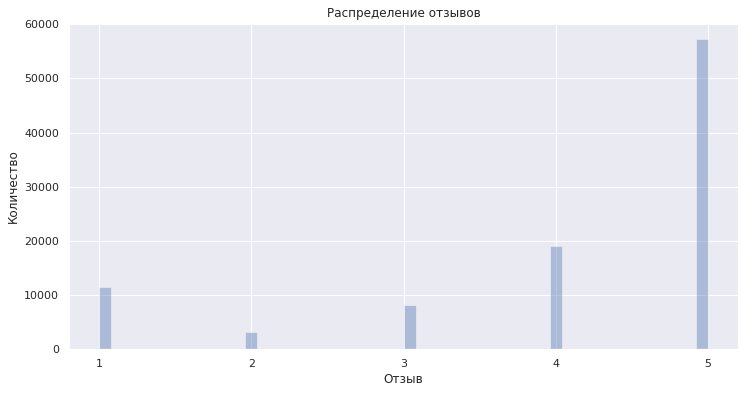

In [7]:
# график распределения оценок
df_score = psql.read_sql('select * from order_reviews', conn)
sns.set(rc={'figure.figsize':(12,6)})
sns.distplot(df_score['review_score'],kde=False, norm_hist=False ).set_title('Распределение отзывов')
plt.xlabel("Отзыв")
plt.ylabel("Количество")
plt.xticks([1, 2, 3, 4, 5])

In [8]:
df_score = psql.read_sql("""
  select distinct      
  o_r.order_id, o_r.review_score, o_r.review_comment_message,o_r.review_creation_date,
  o.order_status,
  c.customer_id, c.customer_unique_id, c.customer_state 
  from order_reviews as o_r
  left join orders as o on o.order_id = o_r.order_id
  left join customers as c on c.customer_id = o.customer_id
  where review_score>0
  """, conn)
df_score.head()

,order_id,review_score,review_comment_message,review_creation_date,order_status,customer_id,customer_unique_id,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,5,"Perfeito, produto entregue antes do combinado.",2017-09-21,delivered,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,RJ
1,00018f77f2f0320c557190d7a144bdd3,4,None,2017-05-13,delivered,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,SP
2,000229ec398224ef6ca0657da4fc703e,5,Chegou antes do prazo previsto e o produto sur...,2018-01-23,delivered,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,MG
3,00024acbcdf0a6daa1e931b038114c75,4,None,2018-08-15,delivered,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,5,Gostei pois veio no prazo determinado .,2017-03-02,delivered,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,SP


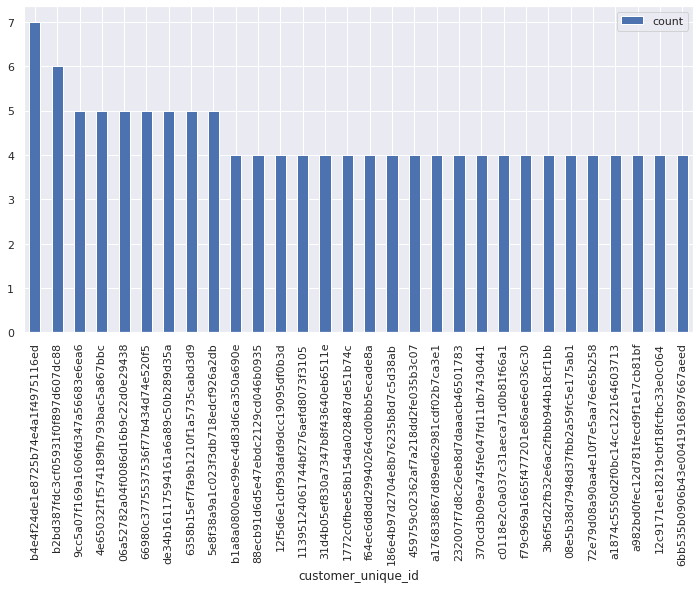

In [9]:
# график распределения отзывов по пользователям
df_score[df_score.review_comment_message.notnull()].groupby(["customer_unique_id"])["order_id"].agg(["count"]).sort_values(["count"], ascending=False).head(30).plot(kind="bar") 

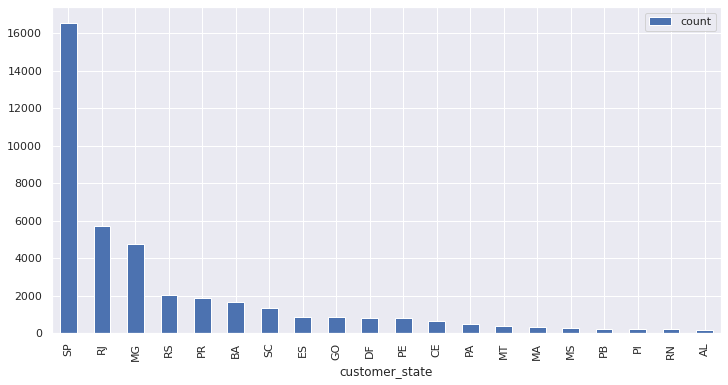

In [10]:
# график распределения отзывов по регионам
df_score[df_score.review_comment_message.notnull()].groupby(["customer_state"])["order_id"].agg(["count"]).sort_values(["count"], ascending=False).head(20).plot(kind="bar") 

In [11]:
# Максимальное кол-во оценок оставил
df_score.groupby(["customer_unique_id"])["order_id"].agg(["count"]).sort_values(["count"], ascending=False).head(1)  

,count
customer_unique_id,
8d50f5eadf50201ccdcedfb9e2ac8455,17


In [12]:
# Максимальное кол-во отзывов оставил
df_score[df_score.review_comment_message.notnull()].groupby(["customer_unique_id"])["order_id"].agg(["count"]).sort_values(["count"], ascending=False).head(1)  

,count
customer_unique_id,
b4e4f24de1e8725b74e4a1f4975116ed,7


In [13]:
df_products = psql.read_sql(""" 
  select *,
  count(*) over(partition by product_category_name) as prod_rows
  from
  (
    select *, 
    count(*) over(partition by order_id) as rows_in_order,
    count(*) over(partition by order_id, product_category_name) as uniq_prod_in_order
    from 
        (
        select distinct
        o_r.order_id, o_r.review_score, o_r.review_comment_message, o_r.review_comment_message,
        o.order_status, o.order_purchase_timestamp, o.order_delivered_customer_date, o_r.review_creation_date, DATE_PART('day', AGE(order_delivered_customer_date, order_purchase_timestamp)) AS DateDiff,
        product_category_name
        from order_reviews as o_r
        left join orders as o on o.order_id = o_r.order_id
        left join order_items as o_i on o_i.order_id = o_r.order_id
        left join products as p on p.product_id = o_i.product_id
        where review_score>0 and order_status='delivered'
        ) as a1
    ) as a2
  where rows_in_order=1 or (rows_in_order>1 and uniq_prod_in_order=rows_in_order) -- в заказе либо один товар, либо все товары одного продукта (оценка выставляется на заказ)
  """, conn)
df_products.head()

,order_id,review_score,review_comment_message,review_comment_message,order_status,order_purchase_timestamp,order_delivered_customer_date,review_creation_date,datediff,product_category_name,rows_in_order,uniq_prod_in_order,prod_rows
0,1c32916fec4ddbdf533e164c2552343f,3,"O produto chegou com pouco de atraso, mas em p...","O produto chegou com pouco de atraso, mas em p...",delivered,2017-05-15 21:52:26,2017-05-23 18:29:02,2017-05-25,7.0,NaN,1,1,1332
1,101157d4fae1c9fb74a00a5dee265c25,5,"Produto excelente, entregue antes do prazo","Produto excelente, entregue antes do prazo",delivered,2017-04-03 07:54:34,2017-04-13 21:08:08,2017-04-14,10.0,NaN,1,1,1332
2,0342b8bec301294021371c16411b6c40,5,None,None,delivered,2017-09-27 16:05:45,2017-10-02 14:33:21,2017-10-03,4.0,NaN,1,1,1332
3,11dd4e8d5273dee8fbe9260bd8e0e5fe,5,Muito bom. Produto entregue bem antes do prazo...,Muito bom. Produto entregue bem antes do prazo...,delivered,2017-06-01 12:30:35,2017-06-19 18:53:48,2017-06-22,18.0,NaN,1,1,1332
4,0b38581eaa98bfe8d55c956b4dab5bcd,5,None,None,delivered,2017-12-27 19:29:42,2018-01-10 11:58:13,2018-01-11,13.0,NaN,1,1,1332


# топ-8 продуктов с самым высоким рейтингом

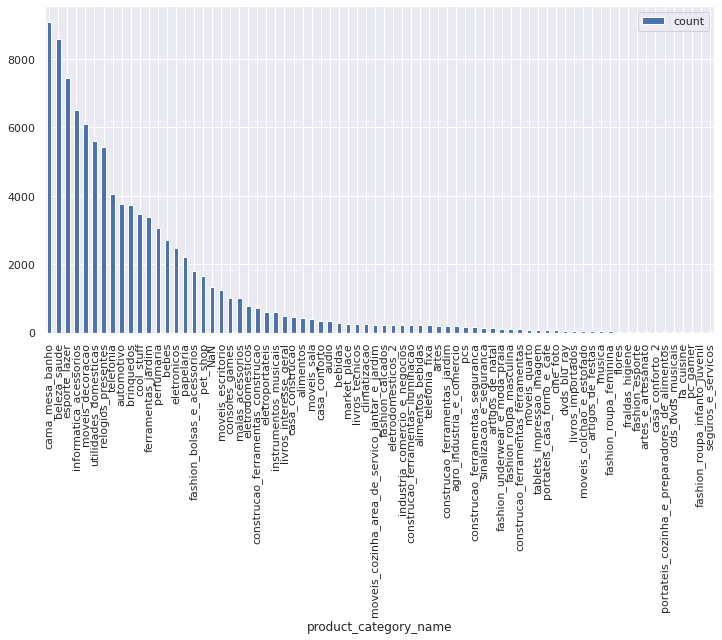

In [14]:
# распределение продуктов  
df_products.groupby(["product_category_name"])["review_score"].agg(["count"]).sort_values(["count"], ascending=False).head(100).plot(kind="bar") 

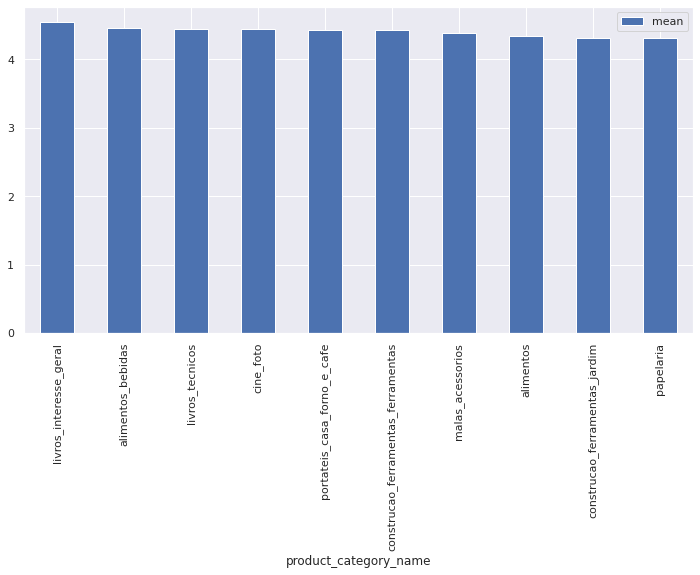

In [15]:
# топ-10 продуктов с самым высоким рейтингом. Берутся продукты, у которых кол-во оценок > 50
df_products[df_products['prod_rows']>=50].groupby(["product_category_name"])["review_score"].agg(["mean"]).sort_values(["mean"], ascending=False).head(10).plot(kind="bar") 

In [16]:
df_products[df_products['prod_rows']>=50].groupby(["product_category_name"])["review_score"].agg(["mean"]).sort_values(["mean"], ascending=False).head(10).reset_index()['product_category_name'].to_list()

['livros_interesse_geral',
 'alimentos_bebidas',
 'livros_tecnicos',
 'cine_foto',
 'portateis_casa_forno_e_cafe',
 'construcao_ferramentas_ferramentas',
 'malas_acessorios',
 'alimentos',
 'construcao_ferramentas_jardim',
 'papelaria']

In [17]:
# список продкутов "топ-10 продуктов с самым высоким рейтингом"
list_high_score = df_products[df_products['prod_rows']>=50].groupby(["product_category_name"])["review_score"].agg(["mean"]).sort_values(["mean"], ascending=False).head(10).reset_index()['product_category_name'].to_list()  

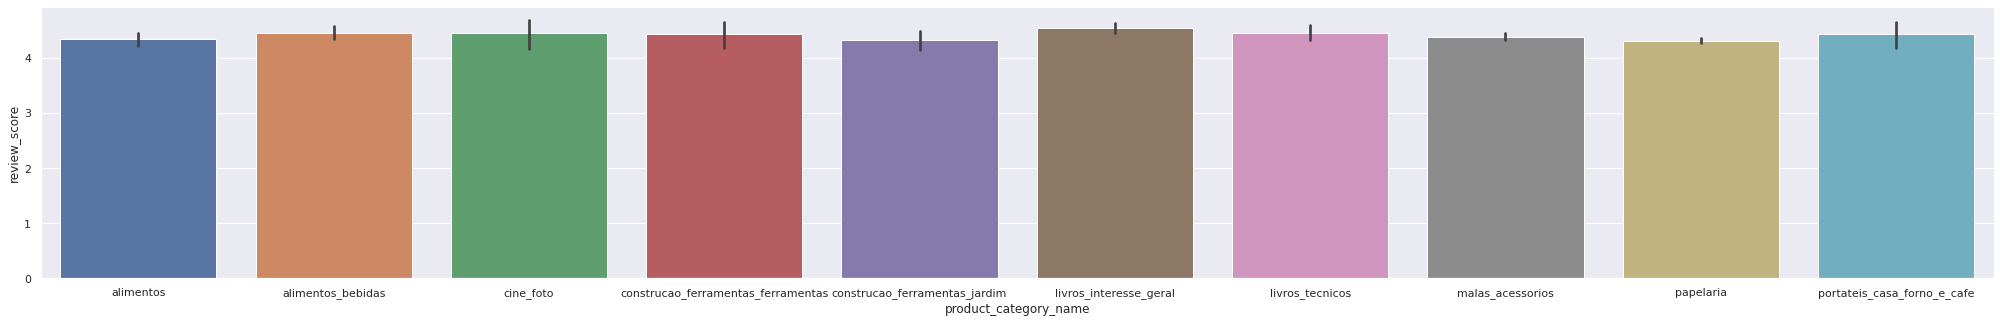

In [18]:
# доверительный инвервал для "топ-10 продуктов с самым высоким рейтингом"
import seaborn as sns
plt.subplots(figsize=(35, 5))
sns.set_theme(style="whitegrid")
tips = df_products[(df_products['product_category_name'].isin(list_high_score))].copy()
ax = sns.barplot(x="product_category_name", y="review_score", data=tips)

In [19]:
# отберем 5 продукта по минимальной доверительной границе рейтинга
df_edited = df_products[(df_products['product_category_name'].isin(list_high_score))].copy()
df1 = df_edited.groupby(["product_category_name"]).agg({'review_score': 'mean', 'datediff': 'mean'}).reset_index()   
df2 = df_edited.groupby(['product_category_name'])["review_score"].std().reset_index()    
df3 = df_edited.groupby(['product_category_name'])["review_score"].count().reset_index()
df_all = df1.merge(df2,on='product_category_name').merge(df3,on='product_category_name')
df_all = df_all.rename(columns={"review_score_x": "mean","review_score_y": "std_val", "review_score": "count"}) 
df_all['minim'] = df_all['mean'] - 1.96*df_all['std_val']/(df_all['count'].astype(float)**(0.5))
df_all = df_all.sort_values(by=['minim'], ascending=False)
df_high_5 = df_all.head(5).copy()
df_high_5.head(5)

,product_category_name,mean,datediff,std_val,count,minim
5,livros_interesse_geral,4.540041,10.030864,0.998939,487,4.451319
1,alimentos_bebidas,4.449541,9.472477,0.935587,218,4.325344
7,malas_acessorios,4.381000,9.813000,1.085826,1000,4.313700
6,livros_tecnicos,4.448413,9.638889,1.108334,252,4.311569
8,papelaria,4.307381,10.620612,1.160481,2222,4.259128


# топ-8 продуктов с самым низким рейтингом

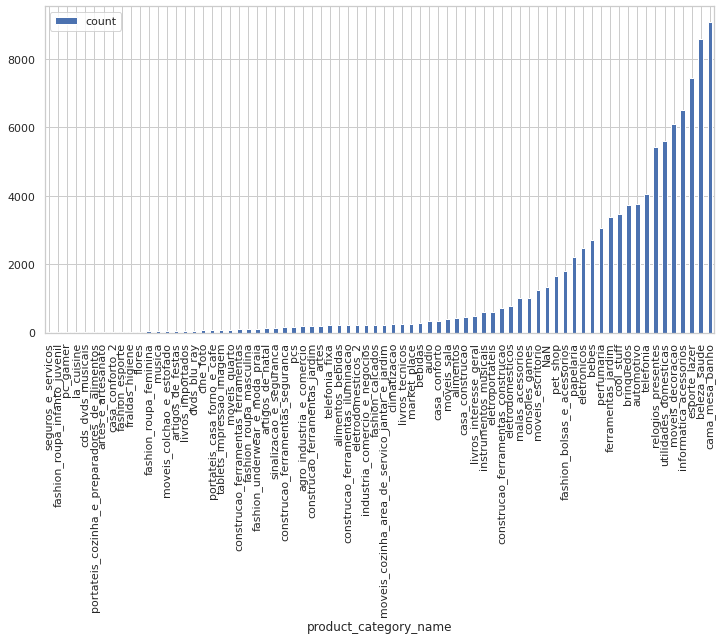

In [20]:
# распределение продуктов по количеству оценок
df_products.groupby(["product_category_name"])["review_score"].agg(["count"]).sort_values(["count"], ascending=True).head(100).plot(kind="bar") 

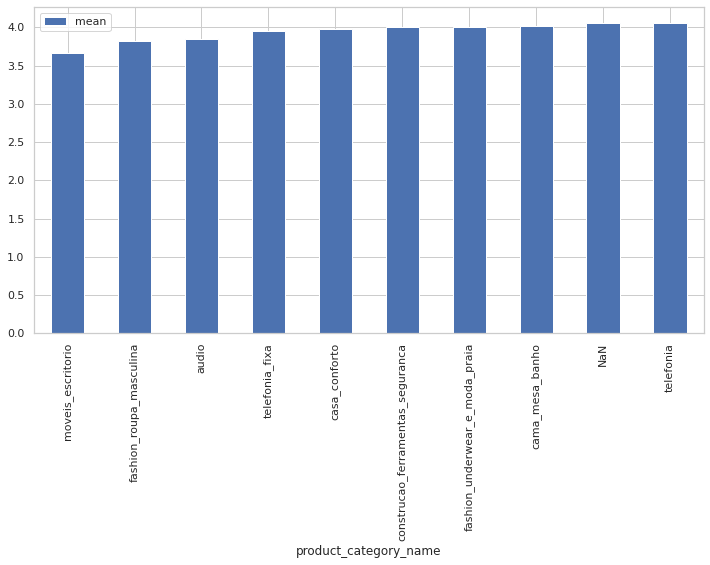

In [21]:
# топ-10 продуктов с самым низким рейтингом. Берутся продукты, у которых кол-во оценок > 50
df_products[df_products['prod_rows']>=50].groupby(["product_category_name"])["review_score"].agg(["mean"]).sort_values(["mean"], ascending=True).head(10).plot(kind="bar") 

In [22]:
# список продкутов "топ-10 продуктов с самым низким рейтингом"
list_low_score = df_products[df_products['prod_rows']>=50].groupby(["product_category_name"])["review_score"].agg(["mean"]).sort_values(["mean"], ascending=True).head(10).reset_index()['product_category_name'].to_list()  

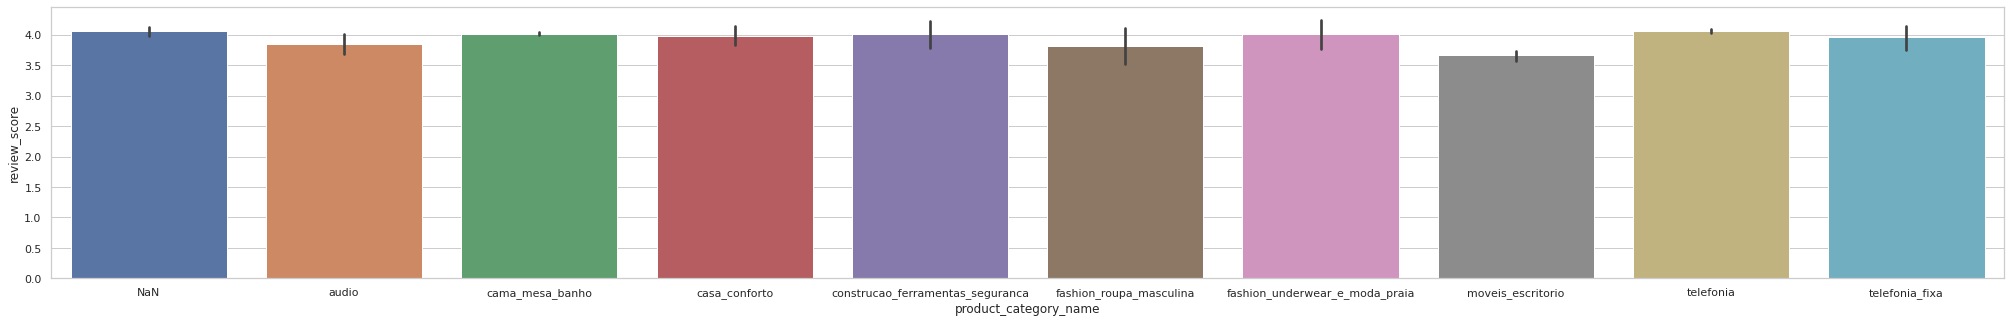

In [23]:
# доверительный инвервал для "топ-10 продуктов с самым низким рейтингом"
import seaborn as sns
plt.subplots(figsize=(35, 5))
sns.set_theme(style="whitegrid")
tips = df_products[(df_products['product_category_name'].isin(list_low_score))].copy()
ax = sns.barplot(x="product_category_name", y="review_score", data=tips)

In [24]:
# отберем 5 продукта по минимальной доверительной границе рейтинга
df_edited = df_products[(df_products['product_category_name'].isin(list_low_score))].copy()
df1 = df_edited.groupby(["product_category_name"]).agg({'review_score': 'mean', 'datediff': 'mean'}).reset_index()  
df2 = df_edited.groupby(['product_category_name'])["review_score"].std().reset_index()    
df3 = df_edited.groupby(['product_category_name'])["review_score"].count().reset_index()
df_all = df1.merge(df2,on='product_category_name').merge(df3,on='product_category_name')
df_all = df_all.rename(columns={"review_score_x": "mean","review_score_y": "std_val", "review_score": "count"}) 
df_all['minim'] = df_all['mean'] - 1.96*df_all['std_val']/(df_all['count'].astype(float)**(0.5))
df_all = df_all.sort_values(by=['minim'], ascending=True)
df_low_5 = df_all.head(5).copy()
df_low_5.head(5)

,product_category_name,mean,datediff,std_val,count,minim
5,fashion_roupa_masculina,3.819048,11.323810,1.585881,105,3.515706
7,moveis_escritorio,3.659643,15.718801,1.466316,1234,3.577830
1,audio,3.844118,11.067647,1.509789,340,3.683633
9,telefonia_fixa,3.956522,10.671498,1.411824,207,3.764190
6,fashion_underwear_e_moda_praia,4.008621,11.982759,1.328587,116,3.766843


# Qestion #4 связь оценок и сроков доставки заказа?

In [25]:
df_low_5

,product_category_name,mean,datediff,std_val,count,minim
5,fashion_roupa_masculina,3.819048,11.323810,1.585881,105,3.515706
7,moveis_escritorio,3.659643,15.718801,1.466316,1234,3.577830
1,audio,3.844118,11.067647,1.509789,340,3.683633
9,telefonia_fixa,3.956522,10.671498,1.411824,207,3.764190
6,fashion_underwear_e_moda_praia,4.008621,11.982759,1.328587,116,3.766843


In [26]:
df_high_5

,product_category_name,mean,datediff,std_val,count,minim
5,livros_interesse_geral,4.540041,10.030864,0.998939,487,4.451319
1,alimentos_bebidas,4.449541,9.472477,0.935587,218,4.325344
7,malas_acessorios,4.381000,9.813000,1.085826,1000,4.313700
6,livros_tecnicos,4.448413,9.638889,1.108334,252,4.311569
8,papelaria,4.307381,10.620612,1.160481,2222,4.259128


In [27]:
# Визуально кажется, что в случае быстрой доставки оценку выше, чем в случае медленной доставки. Проверим так ли это

In [28]:
df_group_high = df_products.merge(df_high_5, on=['product_category_name'], how='inner') 
df_group_low = df_products.merge(df_low_5, on=['product_category_name'], how='inner') 
TG = df_group_high['review_score'].to_list()
CG = df_group_low['review_score'].to_list()

In [29]:
# t-test for independent samples
# function for calculating the t-test for two independent samples
def independent_ttest(data1, data2, alpha):
    mean1, mean2 = mean(data1), mean(data2) # calculate means
    se1, se2 = sem(data1), sem(data2) # calculate standard errors
    sed = sqrt(se1**2.0 + se2**2.0)   # standard error on the difference between the samples
    t_stat = (mean1 - mean2) / sed    # calculate the t statistic
    df3 = len(data1) + len(data2) - 2 # degrees of freedom
    cv = t.ppf(1.0 - alpha, df3)      # calculate the critical value
    p = (1.0 - t.cdf(abs(t_stat), df3)) * 2.0 # calculate the p-value
    return t_stat, df3, cv, p         # return everything

seed(1) # seed the random number generator
data1 = TG # generate two independent samples
data2 = CG
alpha = 0.05 # calculate the t test
t_stat, df3, cv, p = independent_ttest(data1, data2, alpha)
print('t=%.3f, df3=%d, cv=%.3f, p=%.3f' % (t_stat, df3, cv, p))
if abs(t_stat) <= cv: # interpret via critical value
    print('Accept null hypothesis that the means are equal.')
else:
    print('Reject the null hypothesis that the means are equal.')
if p > alpha: # interpret via p-value
    print('Accept null hypothesis that the means are equal.')
else:
    print('Reject the null hypothesis that the means are equal.') 

t=16.647, df3=6179, cv=1.645, p=0.000
Reject the null hypothesis that the means are equal.
Reject the null hypothesis that the means are equal.


In [30]:
# Вывод: средние в выборках стат значимо отличаются, следовательно чем быстрее доставка, тем выше оценка. 
# И наоборот, чем медленее доставка, тем ниже оценка

# Qestion #3 Есть ли связь между оценками и продажами? 
Например, оцените вероятность возвращения клиента после высокой оценки и после низкой. Что будет со средним чеком?

In [31]:
df_price = psql.read_sql(""" 
    select distinct *,
    count(*) over(partition by customer_unique_id) as cus_orders, 
    count(*) over(partition by order_id, purchase_date) as rows_in_order 
    from
      (
        select distinct  customer_unique_id, order_id,review_score,date(order_purchase_timestamp) as purchase_date,
          sum(price) over(partition by order_id) as order_sum,

          rank() over(partition by customer_unique_id order by order_purchase_timestamp) as cus_order_rank,
          rank() over(partition by customer_unique_id, order_id order by order_purchase_timestamp desc) as purchase_date_r,
          rank() over(partition by customer_unique_id, order_id order by review_creation_date desc) as review_date    
          from
              (
              select 
              o_r.order_id, o_r.review_score, o_r.review_comment_message, o_r.review_comment_message,
              o.order_status, o.order_purchase_timestamp, o.order_delivered_customer_date, o_r.review_creation_date, DATE_PART('day', AGE(order_delivered_customer_date, order_purchase_timestamp)) AS DateDiff,
              product_category_name, price,c.customer_unique_id
              from order_reviews as o_r
              left join orders as o on o.order_id = o_r.order_id
              left join order_items as o_i on o_i.order_id = o_r.order_id
              left join customers as c on c.customer_id = o.customer_id
              left join products as p on p.product_id = o_i.product_id
              where review_score>0 and order_status='delivered' and review_score in (1,2,4,5)
              ) as a1  
        ) as a2 
        where purchase_date_r=1 and review_date=1
  """, conn)
df_price.head()

,customer_unique_id,order_id,review_score,purchase_date,order_sum,cus_order_rank,purchase_date_r,review_date,cus_orders,rows_in_order
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,5,2018-05-10,129.90,1,1,1,1,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,4,2018-05-07,18.90,1,1,1,1,1
2,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,4,2017-10-12,25.99,1,1,1,1,1
3,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,5,2017-11-14,180.00,1,1,1,1,1
4,0004bd2a26a76fe21f786e4fbd80607f,3e470077b690ea3e3d501cffb5e0c499,4,2018-04-05,154.00,1,1,1,1,1


In [32]:
# 1 и 2 - низкая оценка
# 4 и 5 - высокая оценка
# возьмем всех клиентов, разделим на 2 группы: высокая и низкая оценка первого заказа. Посчитаем, какая доля в каждой группе совершила повторный заказ 

In [33]:
#  кол-во низких оценок при первом заказе
df_1_low = df_price[(df_price['cus_order_rank']==1)&(df_price['review_score']<3)]['customer_unique_id'].to_list()
df_price[(df_price['cus_order_rank']==1)&(df_price['review_score']<3)][['review_score']].count()

review_score    11998
dtype: int64

In [34]:
#  кол-во высоких оценок при первом заказе
df_1_high = df_price[(df_price['cus_order_rank']==1)&(df_price['review_score']>3)]['customer_unique_id'].to_list()
df_price[(df_price['cus_order_rank']==1)&(df_price['review_score']>3)][['review_score']].count()

review_score    73505
dtype: int64

In [35]:
#  кол-во вторых заказов при низкой оценке
df_price[(df_price['cus_order_rank']==2)&(df_price['customer_unique_id'].isin(df_1_low))][['review_score']].count()

review_score    190
dtype: int64

In [36]:
#  кол-во вторых заказов при высокой оценке
df_price[(df_price['cus_order_rank']==2)&(df_price['customer_unique_id'].isin(df_1_high))][['review_score']].count()

review_score    1621
dtype: int64

In [37]:
# вероятность (%) возвращения клиента после низкой оценки
round(190/11998*100,2)

1.58

In [38]:
# вероятность (%) возвращения клиента после высокой оценки
round(1621/73505*100,2)

2.21

In [39]:
# вывод: Клиент с большей вероятностью вернется во второй раз, если после первого заказа его оценка была положительной, 
# чем клиент, который после первого заказа оставил отрицательную оценку

In [40]:
# ср чек 1-ого заказа с низкой оценкой
df_price[(df_price['cus_order_rank']==1)&(df_price['review_score']<3)][['order_sum']].mean()

order_sum    160.684222
dtype: float64

In [41]:
# ср чек 1-ого заказа с высокой оценкой
df_price[(df_price['cus_order_rank']==1)&(df_price['review_score']>3)][['order_sum']].mean()

order_sum    134.749297
dtype: float64

In [42]:
# ср чек 2-ого заказа после первого заказа с низкой оценкой
df_price[(df_price['cus_order_rank']==2)&(df_price['customer_unique_id'].isin(df_1_low))][['order_sum']].mean()

order_sum    131.176632
dtype: float64

In [43]:
# ср чек 2-ого заказа после первого заказа с высокой оценкой
df_price[(df_price['cus_order_rank']==2)&(df_price['customer_unique_id'].isin(df_1_high))][['order_sum']].mean()

order_sum    124.831314
dtype: float64

In [44]:
TG = df_price[(df_price['cus_order_rank']==2)&(df_price['customer_unique_id'].isin(df_1_low))]['order_sum'].to_list()
CG = df_price[(df_price['cus_order_rank']==2)&(df_price['customer_unique_id'].isin(df_1_high))]['order_sum'].to_list() 
# t-test for independent samples
# function for calculating the t-test for two independent samples
def independent_ttest(data1, data2, alpha):
    mean1, mean2 = mean(data1), mean(data2) # calculate means
    se1, se2 = sem(data1), sem(data2) # calculate standard errors
    sed = sqrt(se1**2.0 + se2**2.0)   # standard error on the difference between the samples
    t_stat = (mean1 - mean2) / sed    # calculate the t statistic
    df3 = len(data1) + len(data2) - 2 # degrees of freedom
    cv = t.ppf(1.0 - alpha, df3)      # calculate the critical value
    p = (1.0 - t.cdf(abs(t_stat), df3)) * 2.0 # calculate the p-value
    return t_stat, df3, cv, p         # return everything

seed(1) # seed the random number generator
data1 = TG # generate two independent samples
data2 = CG
alpha = 0.05 # calculate the t test
t_stat, df3, cv, p = independent_ttest(data1, data2, alpha)
print('t=%.3f, df3=%d, cv=%.3f, p=%.3f' % (t_stat, df3, cv, p))
if abs(t_stat) <= cv: # interpret via critical value
    print('Accept null hypothesis that the means are equal.')
else:
    print('Reject the null hypothesis that the means are equal.')
if p > alpha: # interpret via p-value
    print('Accept null hypothesis that the means are equal.')
else:
    print('Reject the null hypothesis that the means are equal.')  

t=0.595, df3=1809, cv=1.646, p=0.552
Accept null hypothesis that the means are equal.
Accept null hypothesis that the means are equal.


In [45]:
# Вывод: средний чек при повторном заказе в обеих группах не отличается

In [46]:
# португальский - не моя сильная сторона

# Qestion #5 О чем пишут в отзывах? Какие характеристики товаров волнуют пользователей в первую очередь? Какая тональность преобладает? Можно ли по отзыву предсказать оценку? 

In [47]:
df_comments = psql.read_sql("""
  select distinct      
  o_r.order_id, o_r.review_score, o_r.review_comment_message,o_r.review_creation_date,
  o.order_status,
  c.customer_id, c.customer_unique_id, c.customer_state 
  from order_reviews as o_r
  left join orders as o on o.order_id = o_r.order_id
  left join customers as c on c.customer_id = o.customer_id
  where review_score in (1,2,4,5) and length(review_comment_message)>0
  """, conn)
df_comments.head()

,order_id,review_score,review_comment_message,review_creation_date,order_status,customer_id,customer_unique_id,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,5,"Perfeito, produto entregue antes do combinado.",2017-09-21,delivered,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,RJ
1,000229ec398224ef6ca0657da4fc703e,5,Chegou antes do prazo previsto e o produto sur...,2018-01-23,delivered,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,MG
2,00042b26cf59d7ce69dfabb4e55b4fd9,5,Gostei pois veio no prazo determinado .,2017-03-02,delivered,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,SP
3,0005a1a1728c9d785b8e2b08b904576c,1,Na descrição do produto quando fui efetuar a c...,2018-03-30,delivered,16150771dfd4776261284213b89c304e,639d23421f5517f69d0c3d6e6564cf0e,SP
4,00061f2a7bc09da83e415a52dc8a4af1,5,A caixa do produto veio com uma pequena avaria...,2018-03-30,delivered,c6fc061d86fab1e2b2eac259bac71a49,107e6259485efac66428a56f10801f4f,SP


In [48]:
# По длине отзыва нельзя c высокой вероятностью определить тональность

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6deba25150>,
      dtype=object)

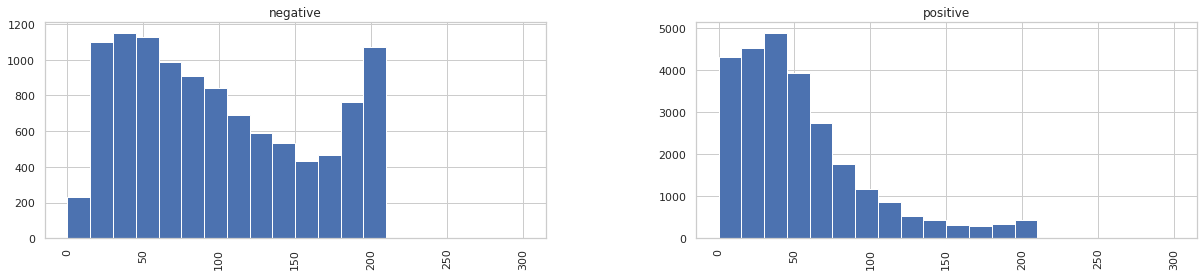

In [49]:
df_comments['sms_length'] = df_comments['review_comment_message'].astype(str).apply(len)
df_comments['type'] = np.where(df_comments['review_score']<3,'negative', 'positive')
df_comments.hist(column='sms_length', by='type', bins=20, figsize=(20,4), range=(0, 300))

In [50]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [51]:
stop_words = stopwords.words('portuguese')
stemmer = SnowballStemmer('portuguese')
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [52]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [53]:
df_comments['review_comment_message'] = df_comments['review_comment_message'].apply(lambda x: preprocess(x))

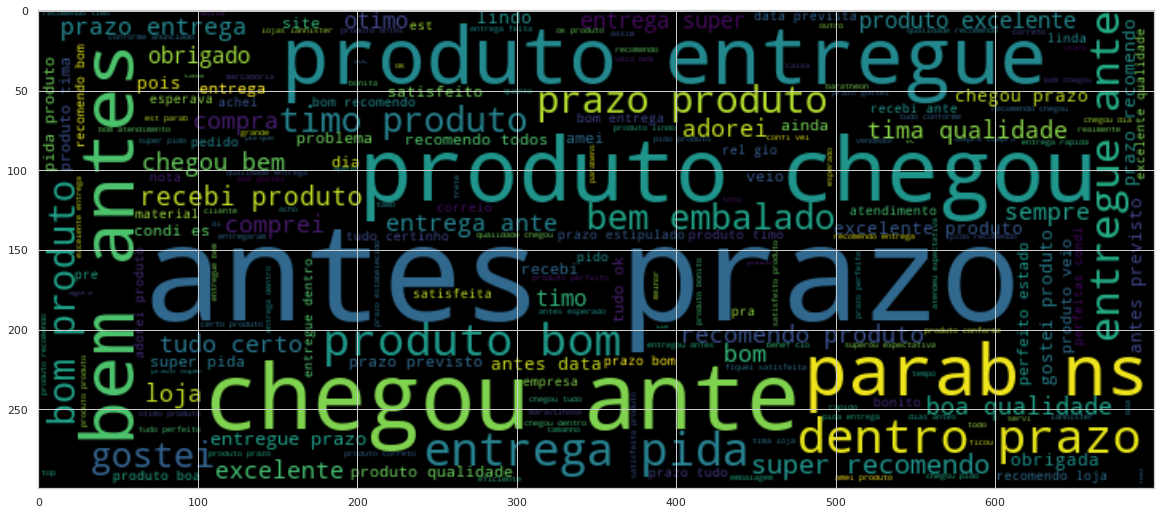

In [54]:
# ключевые слова при высоких оценках
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 200, width = 700 , height = 300).generate(" ".join(df_comments[df_comments.type == 'positive'].review_comment_message))
plt.imshow(wc , interpolation = 'bilinear')

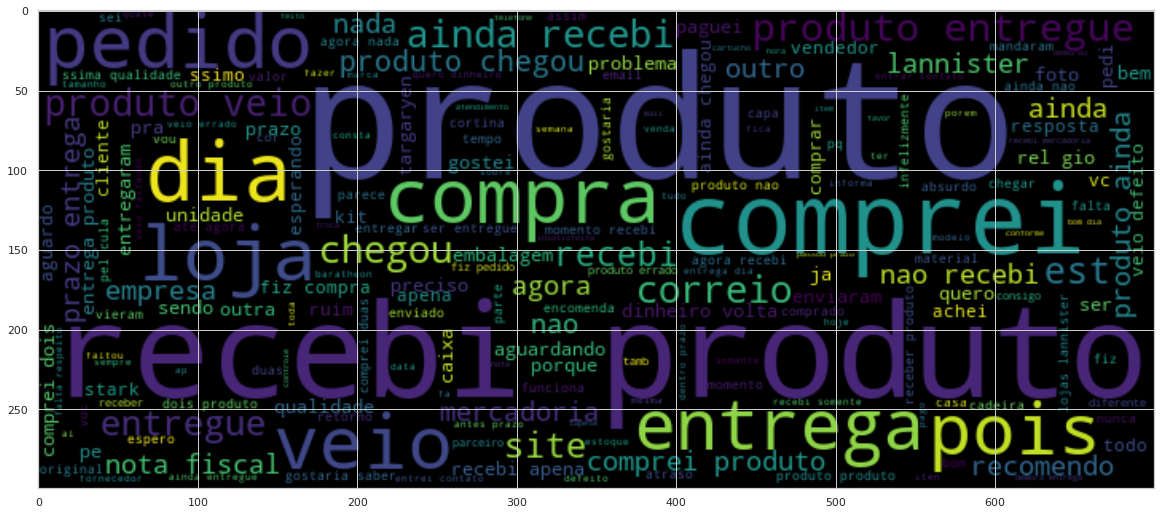

In [55]:
# ключевые слова при низких оценках
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 200, width = 700 , height = 300).generate(" ".join(df_comments[df_comments.type == 'negative'].review_comment_message))
plt.imshow(wc , interpolation = 'bilinear')